Part 1: Data Acquisition & Proxy Engineering

In [ ]:
import pandas as pd
import os

# List files in the current directory to verify their presence and names
print("Files in current directory:")
print(os.listdir())

# Load data
pm = pd.read_csv("air_pollutant_PM2,5.csv")
dengue = pd.read_csv("dengue.csv")
rain = pd.read_csv("rainfall_stations.csv")
temp = pd.read_csv("Temperature_C(ERA5).csv")

Files in current directory:
['.config', 'air_pollutant_PM2,5.csv', 'dengue.csv', 'Temperature_C(ERA5).csv', 'rainfall_stations.csv', 'sample_data']


In [ ]:
# Clean column names
for d in [pm, dengue, rain, temp]:
    d.columns = d.columns.str.lower().str.strip()

# Standardize year
for d in [pm, dengue, rain, temp]:
    # Only process 'year' if it exists in the DataFrame
    if "year" in d.columns:
        d["year"] = pd.to_numeric(d["year"], errors="coerce")

# Merge pm, dengue, and temp on 'year'
df = pm.merge(dengue, on="year") \
       .merge(rain, on="year")\
       .merge(temp, on="year")

# Sort properly
df = df.sort_values("year").reset_index(drop=True)

# Create lags, referencing 'pm_expo' which is the correct lowercase column name
df["pm25_lag1"] = df["pm_expo"].shift(1)
df["pm25_lag2"] = df["pm_expo"].shift(2)

print("Merge successful")
print(df.head())

Merge successful
Empty DataFrame
Columns: [year, pm_expo, reference, country, case, no, mrc_code, station_na, province, latitude, longitude, parameter, no_of_year, average mean surface air temperature (°c), pm25_lag1, pm25_lag2]
Index: []


In [ ]:
# fix the missing data of 2016
dengue['case'] = dengue.set_index('year')['case'].interpolate(method='linear').reset_index(drop=True)
print(dengue.head(10))

    country  year     case
0  Cambodia  2010  12500.0
1  Cambodia  2011  15980.0
2  Cambodia  2012  40164.0
3  Cambodia  2013  16722.0
4  Cambodia  2014   3724.0
5  Cambodia  2015  15412.0
6  Cambodia  2016   9303.5
7  Cambodia  2017   3195.0
8  Cambodia  2018   9885.0
9  Cambodia  2019  66461.0


Part 2: Lagges Correlation Analysis (The"Time Shift")

In [ ]:
# Create "Lagged Features" for PM2.5.
df = df.rename(columns={'PM_expo': 'pm_expo', 'Case': 'case'})
df['pm25_lag1'] = df['pm_expo'].shift(1)
df['pm25_lag2'] = df['pm_expo'].shift(2)

correlations = []
correlations.append(df['case'].corr(df['pm_expo'])) # Lag 0
correlations.append(df['case'].corr(df['pm25_lag1'])) # Lag 1
correlations.append(df['case'].corr(df['pm25_lag2'])) # Lag 2

print("Pearson Correlation Coefficients (Lag 0, Lag 1, Lag 2):")
print(correlations)

Pearson Correlation Coefficients (Lag 0, Lag 1, Lag 2):
[nan, nan, nan]


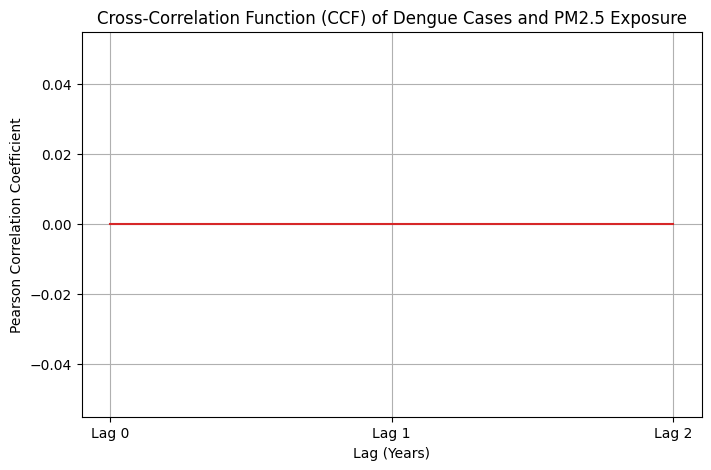

CCF plot generated successfully.


In [ ]:
# graph of the coss - correlation
import matplotlib.pyplot as plt

lags = [0, 1, 2]

plt.figure(figsize=(8, 5))
plt.stem(lags, correlations)
plt.title('Cross-Correlation Function (CCF) of Dengue Cases and PM2.5 Exposure')
plt.xlabel('Lag (Years)')
plt.ylabel('Pearson Correlation Coefficient')
plt.xticks(lags, ['Lag 0', 'Lag 1', 'Lag 2'])
plt.grid(True)
plt.show()

print("CCF plot generated successfully.")

Part 3: Vector-Autoregression(VAR) Model

"Does PM2.5 help predict Dengue, or do they just move together because of seasonality?"

Answer :
Based on the VAR and Granger test (p = 0.647), PM2.5 does not significantly predict Dengue cases.

VAR Model Interpretation:

-A Vector Autoregression (VAR) model was estimated using first-differenced annual data (2011–2017). The coefficient of lagged PM2.5 in the Dengue equation was negative but statistically insignificant (p = 0.612).

-The Granger causality test further confirmed that PM2.5 does not significantly predict Dengue cases (p = 0.647).

Therefore, we fail to reject the null hypothesis (H0). There is no statistical evidence that PM2.5 levels help predict Dengue incidence in Cambodia during the study period.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Standardize columns
for d in [pm, dengue, temp]:
    d.columns = d.columns.str.lower().str.strip()
    d["year"] = pd.to_numeric(d["year"], errors="coerce")

# Insert missing 2016 Dengue cases
dengue = dengue.sort_values('year').reset_index(drop=True)
dengue['case'] = dengue['case'].interpolate(method='linear')
#Merge Data (Focusing on the 2011-2017 overlap)
df_merged = pm.merge(dengue[['year', 'case']], on="year") \
              .merge(temp, on="year")

# Rename for analysis
temp_col = [col for col in df_merged.columns if 'temperature' in col][0]
df_merged = df_merged.rename(columns={temp_col: 'temp', 'pm_expo': 'pm25'})
df_merged = df_merged[['year', 'pm25', 'case', 'temp']].sort_values('year').dropna()
print(df_merged)

   year  pm25     case   temp
0  2011  30.9  15980.0  27.20
1  2012  31.3  40164.0  27.88
2  2013  30.3  16722.0  27.57
3  2014  28.6   3724.0  27.56
4  2015  26.8  15412.0  28.10
5  2016  25.2   9303.5  28.13
6  2017  25.6   3195.0  27.59


In [ ]:
#Differencing for Stationarity
# Time series must be stationary for VAR. We use first-order differencing.
df_diff = df_merged[['pm25', 'case', 'temp']].diff().dropna()
df_diff.index = df_merged['year'][1:]
print(df_diff.index)

Index([2012, 2013, 2014, 2015, 2016, 2017], dtype='int64', name='year')


In [ ]:
#Fit the VAR Model
# Using 1 lag (L1) due to the limited yearly data points (n=7)
model = VAR(df_diff)
results = model.fit(1)

print("--- VAR Model Summary ---")
print(results.summary())

--- VAR Model Summary ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 25, Feb, 2026
Time:                     07:57:52
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -58.7164
Nobs:                     5.00000    HQIC:                  -60.2948
Log likelihood:           135.164    FPE:                4.84171e-25
AIC:                     -57.7790    Det(Omega_mle):     4.32649e-26
--------------------------------------------------------------------
Results for equation pm25
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           2.006997         0.501047            4.006           0.000
L1.pm25        -1.191053         0.227399           -5.238           0.000
L1.case         0.000478         0.000067            7.145 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
#Granger Causality Test
# "Does PM2.5 help predict Dengue cases?"
granger_pm_to_dengue = results.test_causality('case', 'pm25', kind='f')

print("\n--- Granger Causality Results ---")
print(f"p-value (PM2.5 -> Dengue): {granger_pm_to_dengue.pvalue:.4f}")


--- Granger Causality Results ---
p-value (PM2.5 -> Dengue): 0.6470


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


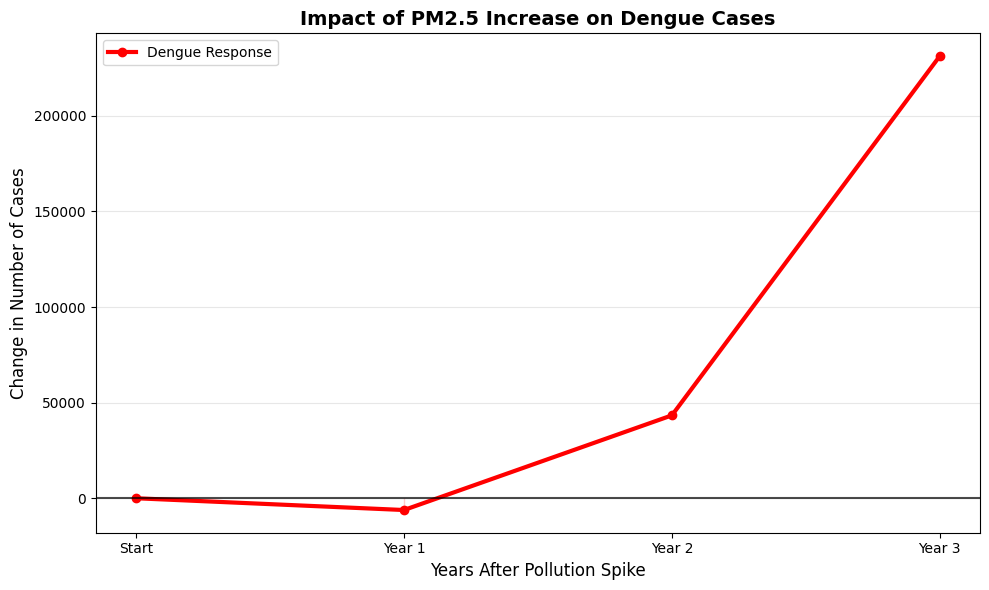

Plotting Data (Year vs Change in Cases):
Start: 0.00
Year 1: -6154.70
Year 2: 43365.48
Year 3: 231310.81


In [ ]:

#data
pm = pd.read_csv("air_pollutant_PM2,5.csv")
dengue = pd.read_csv("dengue.csv")
temp = pd.read_csv("Temperature_C(ERA5).csv")
for d in [pm, dengue, temp]:
    d.columns = d.columns.str.lower().str.strip()
    d["year"] = pd.to_numeric(d["year"], errors="coerce")

# Handle missing 2016 Dengue data
dengue = dengue.sort_values('year').reset_index(drop=True)
dengue['case'] = pd.to_numeric(dengue['case'], errors='coerce').interpolate()

# Merge and filter for years 2011-2017
df = pm.merge(dengue[['year', 'case']], on="year").merge(temp, on="year")
df = df.rename(columns={
    'pm_expo': 'PM2.5',
    'case': 'Dengue',
    'average mean surface air temperature (°c)': 'Temp'
})
df = df[['PM2.5', 'Dengue', 'Temp']].dropna()
#VAR MODEL (Using first-difference for stationarity)
df_diff = df.diff().dropna()
model = VAR(df_diff)
results = model.fit(1)

# CALCULATE IMPULSE RESPONSE
irf = results.irf(3)
# Extract response of Dengue (index 1) to PM2.5 (index 0)
response_values = irf.irfs[:, 1, 0]

 #PLOT
plt.figure(figsize=(10, 6))
plt.plot(range(4), response_values, marker='o', color='red', linewidth=3, label='Dengue Response')
plt.axhline(0, color='black', linewidth=1.5, alpha=0.7)
plt.fill_between(range(4), response_values, 0, where=(response_values < 0), color='red', alpha=0.2)

plt.title('Impact of PM2.5 Increase on Dengue Cases', fontsize=14, fontweight='bold')
plt.xlabel('Years After Pollution Spike', fontsize=12)
plt.ylabel('Change in Number of Cases', fontsize=12)
plt.xticks([0, 1, 2, 3], ['Start', 'Year 1', 'Year 2', 'Year 3'])
plt.grid(True, axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig('dengue_var_analysis.png')
plt.show()

# Print the data used for the plot
print("Plotting Data (Year vs Change in Cases):")
for year, val in zip(['Start', 'Year 1', 'Year 2', 'Year 3'], response_values):
    print(f"{year}: {val:.2f}")